In [254]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None, 'display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import t,f 
from statsmodels.graphics.gofplots import ProbPlot
from sklearn import linear_model, metrics, preprocessing

CRIM: Per capita crime rate by town 

ZN: Proportion of residential land zoned for lots over 25,000 sq. ft

INDUS: Proportion of non-retail business acres per town

CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX: Nitric oxide concentration (parts per 10 million)

RM: Average number of rooms per dwelling

AGE: Proportion of owner-occupied units built prior to 1940

DIS: Weighted distances to five Boston employment centers

RAD: Index of accessibility to radial highways

TAX: Full-value property tax rate per $10,000

PTRATIO: Pupil-teacher ratio by town

B: 1000(Bk — 0.63)², where Bk is the proportion of [people of African American descent] by town

LSTAT: Percentage of lower status of the population

MEDV: Median value of owner-occupied homes in $1000s


In [2]:
Boston = pd.read_csv('./Data/boston.csv')
Boston.info() # check if the dataset contains missing values
Boston.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

#### Check relationship between the reponse medv (median house value) and the predictor lstat (percent of households with low socioeconomic status)

The least-squares solution of X b = y

b_hat = (X^T X)^-1 X^T y

In [270]:
def lr_summary(model, X, y, features=['beta1']):  
    # https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
    N = X.shape[0]
    p = X.shape[1] + 1  # plus one because LinearRegression adds an intercept term

    X_with_intercept = np.empty(shape=(N, p)) # padded with ones
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = X

    beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y # the LS solution

    # leverage score for the ith observation
    hii = np.diagonal(X_with_intercept @ np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T )

    coef = np.array([i[0] for i in beta_hat])
    y_hat = model.predict(X)
    residuals = np.asarray(y) - y_hat
    rss = residuals.T @ residuals
    tss = ((y - y.mean())**2).sum()
    sigma_squared_hat = rss[0, 0] / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat

    dof = X.shape[0] - X.shape[1] - 1 # residual degree of freedom
    R2 = float(1 - rss / tss) # model.score(X, y) # np.sqrt(metrics.r2_score(y, y_hat)) 
    R2_adjusted = float(1 - rss / tss * (N-1) / dof)
    RSE = float(np.sqrt(rss/dof))
    fstat = float((tss - rss) / X.shape[1] / rss * dof)
    fsignf = 2* (1-(f.cdf(fstat, X.shape[1], dof))) # two-sided

    stderr, tstat, pval, l95, u95 = np.zeros(p), np.zeros(p), np.zeros(p), np.zeros(p), np.zeros(p)
    for i in range(p):
        stderr[i] = var_beta_hat[i, i] ** 0.5
        tstat[i] = beta_hat[i] / stderr[i] 
        pval[i] = 2*(t.cdf(-abs(tstat[i]), dof)) # two-sided
        l95[i] = coef[i] - 1.96 * stderr[i]
        u95[i] = coef[i] + 1.96 * stderr[i]

    col_names=['Intercept']
    # print(col_names+features)
    residuals_quartiles = pd.DataFrame(np.quantile(residuals, q=np.linspace(0,1,5)).reshape(-1, 5), columns=['min', '1q', 'median', '3q', 'max'])
    try:
        coef_stats = pd.DataFrame(np.vstack([coef, stderr, tstat, pval, l95, u95]).transpose(), columns=['coef', 'stderr', 'tstat', 'pval', 'l95', 'u95'], index=col_names+features)
    except:
        coef_stats = pd.DataFrame(np.vstack([coef, stderr, tstat, pval, l95, u95]).transpose(), columns=['coef', 'stderr', 'tstat', 'pval', 'l95', 'u95']) 
    regression_stats = pd.DataFrame(np.reshape([np.sqrt(R2), R2, R2_adjusted, RSE, N], (1, 5)), columns=['Mult_R2', 'R2', 'R2_adjusted', 'RSE', 'n_obs'])

    anova_reg = [X.shape[1], float(tss-rss), float(tss-rss)/X.shape[1], fstat, fsignf]
    anova_res = [dof, float(rss), float(rss)/dof, np.nan, np.nan]
    anova_total = [X.shape[0]-1, tss, np.nan, np.nan, np.nan]
    anova = pd.DataFrame([anova_reg, anova_res, anova_total], columns=['df', 'ss', 'ms', 'fstat', 'fsign'], index=['Regress', 'Residual', 'Total'])

    return regression_stats, residuals_quartiles, anova, coef_stats, hii


In [227]:
X, y = np.array(Boston.lstat).reshape(-1, 1), np.array(Boston.loc[:, Boston.columns.isin(['medv'])])
lr_simple = linear_model.LinearRegression().fit(np.array(Boston.lstat).reshape(-1, 1), y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_simple, X, y, features=['lstat'])
regression_stats, residuals_quartiles, anova, coef_stats


(    Mult_R2        R2  R2_adjusted      RSE  n_obs
 0  0.737663  0.544146     0.543242  6.21576  506.0,
          min        1q    median        3q        max
 0 -15.167452 -3.989612 -1.318186  2.033701  24.500129,
            df            ss            ms       fstat         fsign
 Regress     1  23243.913997  23243.913997  601.617871  2.220446e-16
 Residual  504  19472.381418     38.635677         NaN           NaN
 Total     505  42716.295415           NaN         NaN           NaN,
                 coef    stderr      tstat           pval        l95        u95
 Intercept  34.553841  0.562627  61.415146  3.743081e-236  33.451091  35.656590
 lstat      -0.950049  0.038733 -24.527900   5.081103e-88  -1.025967  -0.874132)

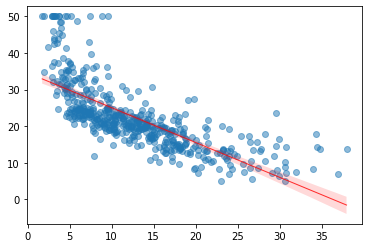

In [5]:
def plot_regline(X, y):
    plt.scatter(X, y)
    lx = np.linspace(X.min(), X.max(), 20)
    ly = np.vstack([np.ones(lx.shape[0]), lx]).T @ np.array(coef_stats.coef.tolist())
    plt.plot(lx, ly, color='red');
# fig, axes = plt.subplots(1,2, figsize=(16,4))
# plt.subplot(1,2,1)
# plot_regline(X, y)
sns.regplot(x=X, y=y, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
# non-linearity in the relationship between medv and lstat

Check for common problems related to linear regression: 
<li> Non-linearity of the response-predictor relationships
<!-- <li> Correlation of error (useful for time series data) -->
<li> Non-constant variance of error terms
<li> Outliers
<li> High leverage points
<li> Colinearity

([166, 186, 225, 257, 262, 267, 369, 371, 372], [374])

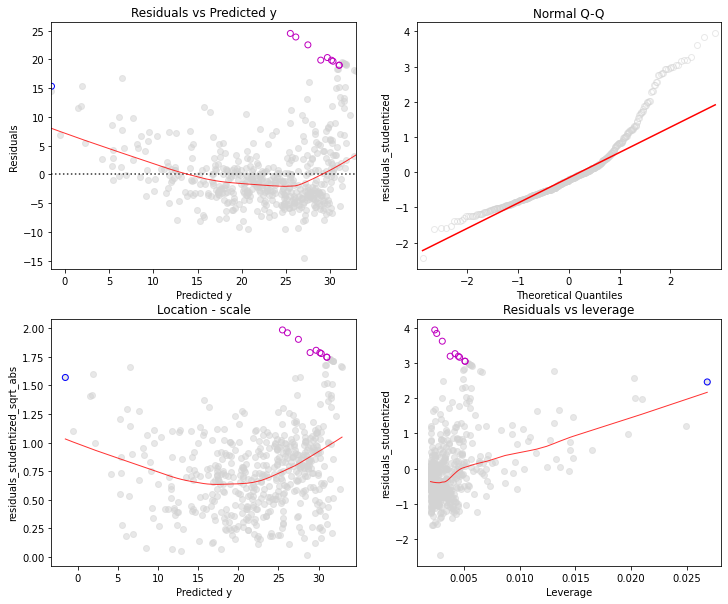

In [109]:
def check_lm(lr_simple, X, y):
    y_pred = lr_simple.predict(X)
    residuals = y - y_pred
    residuals.shape
    residuals_studentized = residuals / float(regression_stats.RSE)
    residuals_studentized = residuals_studentized.reshape(1, residuals_studentized.shape[0])[0]
    residuals_studentized_sqrt_abs = np.sqrt(abs(residuals_studentized))
    outlier_ind = [i for i in range(len(residuals_studentized)) if residuals_studentized[i]>3]
    outlier_indT = residuals_studentized > 3
    hl_threshold = .025
    hl_ind = [i for i in range(len(hii)) if hii[i]>hl_threshold]
    hl_indT = hii[i]>hl_threshold 

    fig, axes = plt.subplots(2,2, figsize=(12,10))
    sns.residplot(x=y_pred[~outlier_indT], y=residuals[~outlier_indT], lowess=True, color='lightgrey', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axes[0, 0]);
    axes[0,0].scatter(x=y_pred[outlier_indT], y=residuals[outlier_indT], edgecolor='m', facecolor='None')
    axes[0,0].scatter(x=y_pred[hl_ind], y=residuals[hl_ind], edgecolor='b', facecolor='None')
    axes[0,0].set_title('Residuals vs Predicted y')
    axes[0,0].set_xlabel('Predicted y')
    axes[0,0].set_ylabel('Residuals');

    QQ = ProbPlot(residuals_studentized, dist=stats.norm)
    sm.qqplot(QQ.data, line='q', alpha=0.5, lw=.5, markerfacecolor='None', markeredgecolor='lightgrey', ax=axes[0, 1]);
    axes[0,1].set_ylabel('residuals_studentized');
    axes[0,1].set_title('Normal Q-Q')

    sns.regplot(x=y_pred[~outlier_indT], y=residuals_studentized_sqrt_abs[~outlier_indT], scatter=True, color='lightgrey', scatter_kws={'alpha': 0.5},lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axes[1, 0]);
    axes[1,0].scatter(x=y_pred[outlier_indT], y=residuals_studentized_sqrt_abs[outlier_indT], edgecolor='m', facecolor='None')
    axes[1,0].scatter(x=y_pred[hl_ind], y=residuals_studentized_sqrt_abs[hl_ind], edgecolor='b', facecolor='None')
    axes[1,0].set_xlabel('Predicted y')
    axes[1,0].set_ylabel('residuals_studentized_sqrt_abs');
    axes[1,0].set_title('Location - scale')

    sns.regplot(x=hii[~outlier_indT], y=residuals_studentized[~outlier_indT], scatter=True, color='lightgrey', scatter_kws={'alpha': 0.5},lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axes[1, 1]);
    axes[1,1].scatter(x=hii[outlier_ind], y=residuals_studentized[outlier_ind], edgecolor='m', facecolor='None')
    axes[1,1].scatter(x=hii[hl_ind], y=residuals_studentized[hl_ind], edgecolor='b', facecolor='None')
    axes[1,1].set_ylabel('residuals_studentized')
    axes[1,1].set_xlabel('Leverage')
    axes[1,1].set_title('Residuals vs leverage');
    # for i, txt in enumerate(outlier_ind):
    #     # print((hii[outlier_ind[i]], residuals_studentized[outlier_ind[i]]))
    #     axes[1,1].annotate(txt, (hii[outlier_ind[i]], residuals_studentized[outlier_ind[i]]))
    return outlier_ind, hl_ind

outlier_ind, hl_ind = check_lm(lr_simple, X, y)
outlier_ind, hl_ind

In [113]:
# To be finished .... 
X_test = np.array([[5], [10], [15]])
# lr_simple.predict(X_test)

# # print(np.array(coef_stats.coef.tolist()).reshape(-1,1).shape, X_test.shape)
# np.array(coef_stats.coef.tolist()).T
# np.vstack([ np.ones(X_test.shape[0]), X_test.reshape(1, X_test.shape[0])]).T

X_test_pad = np.vstack([ np.ones(X_test.shape[0]), X_test.reshape(1, X_test.shape[0])]) # pad ones for X_train
y_pred = np.matmul(X_test_pad.T, np.array(coef_stats.coef.tolist())) 
# y_pred_l95 = np.matmul(X_test_pad.T, np.array(coef_stats.l95.tolist()))
# y_pred_l95 = y_pred + 

y_pred_u95 = np.matmul(X_test_pad.T, np.array(coef_stats.u95.tolist()))  
# pd.DataFrame(np.vstack([y_pred, y_pred_l95, y_pred_u95]).transpose(), columns=['y_pred', 'y_pred_l95', 'y_pred_u95'])

##### Non-linear Transformations of the Predictors: polynomials

In [315]:
features = ['lstat']
X, y = np.array(Boston.lstat).reshape(-1, 1), np.array(Boston.loc[:, Boston.columns.isin(['medv'])])
power = 2
poly = preprocessing.PolynomialFeatures(degree=power, interaction_only=False)
X_poly = poly.fit_transform(X)
lr_poly = linear_model.LinearRegression().fit(X_poly[:, np.arange(1,power+1)], y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_poly, X_poly[:, np.arange(1,power+1)], y, features=poly.get_feature_names(features)[1:])
regression_stats, residuals_quartiles, anova, coef_stats


(    Mult_R2        R2  R2_adjusted       RSE  n_obs
 0  0.800448  0.640717     0.639288  5.523714  506.0,
          min        1q  median        3q       max
 0 -15.283395 -3.831307 -0.5295  2.309535  25.41481,
            df            ss            ms       fstat         fsign
 Regress     2  27369.052257  13684.526128  448.505088  2.220446e-16
 Residual  503  15347.243158     30.511418         NaN           NaN
 Total     505  42716.295415           NaN         NaN           NaN,
                 coef    stderr      tstat           pval        l95        u95
 Intercept  42.862007  0.872084  49.148921  3.500749e-194  41.152722  44.571293
 lstat      -2.332821  0.123803 -18.842963   2.548861e-60  -2.575476  -2.090167
 lstat^2     0.043547  0.003745  11.627546   7.630116e-28   0.036206   0.050887)

In [314]:
features = ['lstat']
X, y = np.array(Boston.lstat).reshape(-1, 1), np.array(Boston.loc[:, Boston.columns.isin(['medv'])])
power = 5
poly = preprocessing.PolynomialFeatures(degree=power, interaction_only=False)
X_poly = poly.fit_transform(X)
lr_poly = linear_model.LinearRegression().fit(X_poly[:, np.arange(1,power+1)], y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_poly, X_poly[:, np.arange(1,power+1)], y, features=poly.get_feature_names(features)[1:])
regression_stats, residuals_quartiles, anova, coef_stats

(    Mult_R2       R2  R2_adjusted       RSE  n_obs
 0  0.825645  0.68169     0.678507  5.214793  506.0,
          min        1q    median        3q        max
 0 -13.543286 -3.103925 -0.705232  2.084364  27.115265,
            df            ss           ms       fstat         fsign
 Regress     5  29119.260388  5823.852078  214.158898  2.220446e-16
 Residual  500  13597.035027    27.194070         NaN           NaN
 Total     505  42716.295415          NaN         NaN           NaN,
                 coef    stderr      tstat          pval        l95        u95
 Intercept  67.699677  3.604295  18.783058  5.928760e-60  60.635259  74.764094
 lstat     -11.991117  1.525718  -7.859327  2.387501e-14 -14.981524  -9.000710
 lstat^2     1.272818  0.223167   5.703436  2.011461e-08   0.835411   1.710225
 lstat^3    -0.068274  0.014382  -4.747082  2.698544e-06  -0.096463  -0.040085
 lstat^4     0.001726  0.000417   4.142581  4.032078e-05   0.000909   0.002543
 lstat^5    -0.000016  0.000004  -3.6

Interaction terms

Use the sklearn.preprocessing api

In [324]:
features = ['lstat', 'age']
X, y = np.array(Boston_interaction.loc[:, features]), np.array(Boston_interaction.loc[:, ['medv']])
power = 2
poly = preprocessing.PolynomialFeatures(degree=power, interaction_only=True)
X_poly = poly.fit_transform(X)
lr_poly = linear_model.LinearRegression().fit(X_poly[:, np.arange(1,power+2)], y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_poly, X_poly[:, np.arange(1,power+2)], y, features=poly.get_feature_names(features)[1:])
regression_stats, residuals_quartiles, anova, coef_stats

(    Mult_R2        R2  R2_adjusted       RSE  n_obs
 0  0.745471  0.555727     0.553072  6.148513  506.0,
          min        1q    median        3q        max
 0 -15.806521 -4.044681 -1.333163  2.084707  27.552059,
            df            ss           ms       fstat         fsign
 Regress     3  23738.579270  7912.859757  209.311572  2.220446e-16
 Residual  502  18977.716145    37.804215         NaN           NaN
 Total     505  42716.295415          NaN         NaN           NaN,
                 coef    stderr      tstat          pval        l95        u95
 Intercept  36.088536  1.469835  24.552773  4.907116e-88  33.207658  38.969413
 lstat      -1.392117  0.167456  -8.313352  8.780730e-16  -1.720330  -1.063904
 age        -0.000721  0.019879  -0.036262  9.710878e-01  -0.039684   0.038242
 lstat age   0.004156  0.001852   2.244283  2.524911e-02   0.000526   0.007785)

In [325]:
# Alternative approach (same results)
features = ['lstat', 'age']
Boston_interaction = Boston.copy()
Boston_interaction['age_lstat'] = Boston_interaction['age'] * Boston_interaction['lstat']
X, y = np.array(Boston_interaction.loc[:, features+['age_lstat']]), np.array(Boston_interaction.loc[:, ['medv']])
lr_multi5 = linear_model.LinearRegression().fit(X, y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_multi5, X, y, features+['age_lstat'])
regression_stats, residuals_quartiles, anova, coef_stats

(    Mult_R2        R2  R2_adjusted       RSE  n_obs
 0  0.745471  0.555727     0.553072  6.148513  506.0,
          min        1q    median        3q        max
 0 -15.806521 -4.044681 -1.333163  2.084707  27.552059,
            df            ss           ms       fstat         fsign
 Regress     3  23738.579270  7912.859757  209.311572  2.220446e-16
 Residual  502  18977.716145    37.804215         NaN           NaN
 Total     505  42716.295415          NaN         NaN           NaN,
                 coef    stderr      tstat          pval        l95        u95
 Intercept  36.088536  1.469835  24.552773  4.907116e-88  33.207658  38.969413
 lstat      -1.392117  0.167456  -8.313352  8.780730e-16  -1.720330  -1.063904
 age        -0.000721  0.019879  -0.036262  9.710878e-01  -0.039684   0.038242
 age_lstat   0.004156  0.001852   2.244283  2.524911e-02   0.000526   0.007785)

#### Multiple Linear Regression

In [340]:
features=list(Boston.columns[~Boston.columns.isin(['black','medv'])])
Boston.loc[:, features].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/1z/mw5rcnwj0n39jr4gbqtn6_400000gn/T/ipykernel_3664/2654527565.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  Boston.loc[:, features].corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
crim,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,0.46
zn,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,-0.41
indus,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,0.60
chas,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,-0.05
nox,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,0.59
rm,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,-0.61
age,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,0.60
dis,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,-0.50
rad,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,0.49
tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,0.54


In [228]:
X, y = np.array(Boston.loc[:, ['lstat', 'age']]), np.array(Boston.loc[:, ['medv']])
lr_multi = linear_model.LinearRegression().fit(X, y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_multi, X, y, features=['lstat', 'age'])
regression_stats, residuals_quartiles, anova, coef_stats

(    Mult_R2        R2  R2_adjusted       RSE  n_obs
 0  0.742475  0.551269     0.549485  6.173136  506.0,
          min       1q    median        3q        max
 0 -15.981243 -3.97747 -1.283443  1.968309  23.158419,
            df            ss            ms       fstat         fsign
 Regress     2  23548.166806  11774.083403  308.969335  2.220446e-16
 Residual  503  19168.128609     38.107612         NaN           NaN
 Total     505  42716.295415           NaN         NaN           NaN,
                 coef    stderr      tstat           pval        l95        u95
 Intercept  33.222761  0.730847  45.457881  2.943785e-180  31.790300  34.655221
 lstat      -1.032069  0.048191 -21.416330   8.419554e-73  -1.126522  -0.937615
 age         0.034544  0.012225   2.825605   4.906776e-03   0.010582   0.058506)

In [239]:
def feature_variance_inflation_factor(Boston, features=list(Boston.columns[~Boston.columns.isin(['black','medv'])])):
    # https://en.wikipedia.org/wiki/Variance_inflation_factor
    # features = list(Boston.columns[~Boston.columns.isin(['black','medv'])]) 
    coef_vif = []
    for feature in features:
        features_leaveout = [i for i in features if i !=feature]
        # print(feature, features_leaveout)
        # First we run an ordinary least square regression that has feature as a function of all the other explanatory variables (ie features_leaveout)
        X_vif, y_vif = np.array(Boston.loc[:, features_leaveout]), np.array(Boston.loc[:, feature])
        lr_vif = linear_model.LinearRegression().fit(X_vif, y_vif)
        vif_feature = 1. / (1. - metrics.r2_score(y_pred=lr_vif.predict(X_vif), y_true=y_vif))
        coef_vif.append( vif_feature)

    return pd.DataFrame(coef_vif, index=features)

In [241]:
features=list(Boston.columns[~Boston.columns.isin(['black','medv'])])
X, y = np.array(Boston.loc[:, features]), np.array(Boston.loc[:, ['medv']])
lr_multi1 = linear_model.LinearRegression().fit(X, y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_multi1, X, y, features)
regression_stats, residuals_quartiles, anova, coef_stats

(    Mult_R2        R2  R2_adjusted       RSE  n_obs
 0  0.856917  0.734307      0.72784  4.798034  506.0,
          min        1q    median        3q        max
 0 -15.130369 -2.767258 -0.581396  1.941429  26.252609,
            df            ss           ms       fstat         fsign
 Regress    12  31366.876607  2613.906384  113.543774  2.220446e-16
 Residual  493  11349.418808    23.021133         NaN           NaN
 Total     505  42716.295415          NaN         NaN           NaN,
                 coef    stderr      tstat          pval        l95        u95
 Intercept  41.617270  4.936039   8.431308  3.794467e-16  31.942633  51.291908
 crim       -0.121389  0.033000  -3.678399  2.605302e-04  -0.186069  -0.056708
 zn          0.046963  0.013879   3.383750  7.719966e-04   0.019760   0.074167
 indus       0.013468  0.062145   0.216715  8.285201e-01  -0.108336   0.135271
 chas        2.839993  0.870007   3.264333  1.173458e-03   1.134779   4.545208
 nox       -18.758022  3.851355  -4

In [242]:
feature_variance_inflation_factor(Boston, features)

,0
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


Note: indus and age have high p-values. rad and tax have high variance inflation factors, indicating colinearity

In [233]:
features=list(Boston.columns[~Boston.columns.isin(['indus', 'age', 'black','medv'])])
X, y = np.array(Boston.loc[:, features]), np.array(Boston.loc[:, ['medv']])
lr_multi2 = linear_model.LinearRegression().fit(X, y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_multi2, X, y, features)
regression_stats, residuals_quartiles, anova, coef_stats

(    Mult_R2        R2  R2_adjusted       RSE  n_obs
 0  0.856879  0.734242     0.728873  4.788915  506.0,
          min        1q    median        3q        max
 0 -15.181415 -2.762467 -0.624346  1.844759  26.391997,
            df            ss           ms       fstat         fsign
 Regress    10  31364.108936  3136.410894  136.759856  2.220446e-16
 Residual  495  11352.186479    22.933710         NaN           NaN
 Total     505  42716.295415          NaN         NaN           NaN,
                 coef    stderr      tstat          pval        l95        u95
 Intercept  41.451747  4.903283   8.453876  3.176661e-16  31.841312  51.062182
 crim       -0.121665  0.032919  -3.695891  2.435786e-04  -0.186186  -0.057144
 zn          0.046191  0.013673   3.378348  7.867310e-04   0.019393   0.072990
 chas        2.871873  0.862591   3.329356  9.353905e-04   1.181194   4.562551
 nox       -18.262427  3.565247  -5.122346  4.330925e-07 -25.250311 -11.274543
 rm          3.672957  0.409127   8

In [235]:
features=list(Boston.columns[~Boston.columns.isin(['tax', 'indus', 'age', 'black','medv'])])
X, y = np.array(Boston.loc[:, features]), np.array(Boston.loc[:, ['medv']])
lr_multi3 = linear_model.LinearRegression().fit(X, y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_multi3, X, y, features)
regression_stats, residuals_quartiles, anova, coef_stats

(    Mult_R2        R2  R2_adjusted      RSE  n_obs
 0  0.852791  0.727253     0.722304  4.84659  506.0,
          min        1q    median        3q       max
 0 -15.855025 -2.988036 -0.547744  1.877009  26.41051,
            df            ss           ms       fstat         fsign
 Regress     9  31065.536130  3451.726237  146.948038  2.220446e-16
 Residual  496  11650.759285    23.489434         NaN           NaN
 Total     505  42716.295415          NaN         NaN           NaN,
                 coef    stderr      tstat          pval        l95        u95
 Intercept  39.984050  4.945230   8.085377  4.781222e-15  30.291400  49.676701
 crim       -0.118542  0.033304  -3.559405  4.074574e-04  -0.183818  -0.053266
 zn          0.036576  0.013572   2.694957  7.278674e-03   0.009975   0.063177
 chas        3.139442  0.869748   3.609602  3.378215e-04   1.434737   4.844147
 nox       -21.375663  3.500926  -6.105717  2.067242e-09 -28.237479 -14.513848
 rm          3.850564  0.411046   9.367

In [358]:
features=list(Boston.columns[~Boston.columns.isin(['tax', 'rad', 'indus', 'age', 'black','medv'])])
X, y = np.array(Boston.loc[:, features]), np.array(Boston.loc[:, ['medv']])
lr_multi4 = linear_model.LinearRegression().fit(X, y)
regression_stats, residuals_quartiles, anova, coef_stats, hii = lr_summary(lr_multi4, X, y, features)
regression_stats, residuals_quartiles, anova, coef_stats

(    Mult_R2        R2  R2_adjusted       RSE  n_obs
 0  0.850661  0.723624     0.719175  4.873813  506.0,
         min        1q    median        3q        max
 0 -15.52191 -2.976606 -0.616149  1.725575  27.657821,
            df            ss           ms       fstat         fsign
 Regress     8  30910.530475  3863.816309  162.659236  2.220446e-16
 Residual  497  11805.764940    23.754054         NaN           NaN
 Total     505  42716.295415          NaN         NaN           NaN,
                 coef    stderr      tstat          pval        l95        u95
 Intercept  34.999814  4.574250   7.651487  1.039533e-13  26.034285  43.965344
 crim       -0.080422  0.029983  -2.682281  7.555648e-03  -0.139187  -0.021656
 zn          0.041090  0.013533   3.036205  2.521515e-03   0.014565   0.067615
 chas        3.170453  0.874549   3.625245  3.184512e-04   1.456338   4.884568
 nox       -17.718775  3.216399  -5.508886  5.803679e-08 -24.022916 -11.414634
 rm          4.009979  0.408617   9.8